# **Final Project - Diabetes likelihood prediction.**
#### Liron Balastra, Coral Kuta

We will overview the [diabetes dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset) to assess and predict the likelihood of diabetes in patients based on their medical history and demographic details - gender, BMI, age, smoking history, etc.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Diabetes Prediction in Patiens:

**Imports**:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import re
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from xgboost import plot_tree
from xgboost import XGBRegressor
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# loading the Dataset
dtf=pd.read_csv("/content/drive/MyDrive/kaggle/diabetes_prediction_dataset.csv")
dtf.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# Analyzing Data

In [ ]:
dtf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


## Basic Analyze

In [ ]:
dtf.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [ ]:
dtf.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

## Sanitize Dataset

In [ ]:
# there are no empty values in the DB
dtf.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

First thing we wanted to address is the 'Other' value in 'Gender' attribute.
There are 18 datapoints with Gender='Other'.

When talking about 100K datapoints, 18 seem not much, so we chose to remove them

In [ ]:
# remove Gender='Other'
dtf = dtf[dtf['gender'] != 'Other']

# verify there are no 'Other'
print(dtf['gender'].value_counts())


gender
Female    58552
Male      41430
Name: count, dtype: int64


###Missing Data

In the 'Diabetes' DB, only "smoking_history" column had null values. They are represented as "No Info". 35816 rows include "No info" value.

To fix this gap we thought about several options, but the type of this column is not numerical, So fill the "No info" value with mean or mode doesn't seem like the right solution.

In [ ]:
print(dtf['smoking_history'].value_counts())

smoking_no_info_count = (dtf['smoking_history'].str.lower() == 'no info').sum()
sampels_count = dtf.shape[0]
print("\nTotal rows: ", sampels_count)


smoking_history
No Info        35810
never          35092
former          9352
current         9286
not current     6439
ever            4003
Name: count, dtype: int64

Total rows:  99982


Our soultion is to treat the "No info" value as "never".

The next code genertes graph that showes the people smoeking distribution.

We can see that pepole with "No Info" value for smoking_history, had similar distribution as pepole with "never" value.

In [ ]:
# Group by smoking_history and diabetes, count occurrences
smoking_perc = dtf.groupby(['smoking_history', 'diabetes'], as_index=False)['diabetes'].count()

# Define labels for colors
smoking_labels = [
    'Current | Normal',
    'Current | Diabetic',
    'Ever | Normal',
    'Ever | Diabetic',
    'Former | Normal',
    'Former | Diabetic',
    'Never | Normal',
    'Never | Diabetic',
    'No Info | Normal',
    'No Info | Diabetic',
    'Not Current | Normal',
    'Not Current | Diabetic',
]

# Create bar chart
fig_smoking = px.bar(
    smoking_perc,
    x='smoking_history',
    y='diabetes',
    title='Smoking History and Diabetes',
    color='diabetes',
    labels={'diabetes': 'Number of Individuals'},
    category_orders={'smoking_history': ['current', 'ever', 'former', 'never', 'No Info ', 'not current']},
    color_discrete_sequence=px.colors.qualitative.Set1
)

# Update text properties
fig_smoking.update_traces(
    textposition='inside',
    insidetextanchor='middle',
    insidetextfont={'color': 'white', 'size': 13}
)

# Update layout
fig_smoking.update_layout(
    title_x=0.5,
    xaxis_title='Smoking History',
    yaxis_title='Number of Individuals',
    legend_title=''
)

# # Show the figure
fig_smoking.show()


In [ ]:
# Replace "No Info" with "never" in the 'smoking_history' column
dtf['smoking_history'] = dtf['smoking_history'].str.replace('No Info', 'never', case=False)


Ensuring there is no "No Info" value after the change:

In [ ]:
print(dtf['smoking_history'].value_counts())

smoking_history
never          70902
former          9352
current         9286
not current     6439
ever            4003
Name: count, dtype: int64


###Outliers
Outliers are data points that deviate significantly from the rest of the dataset.
They can skew statistical analyses and compromise the performance of machine learning models.
Detecting and properly handling outliers is essential for maintaining the accuracy and reliability of data-driven processes.

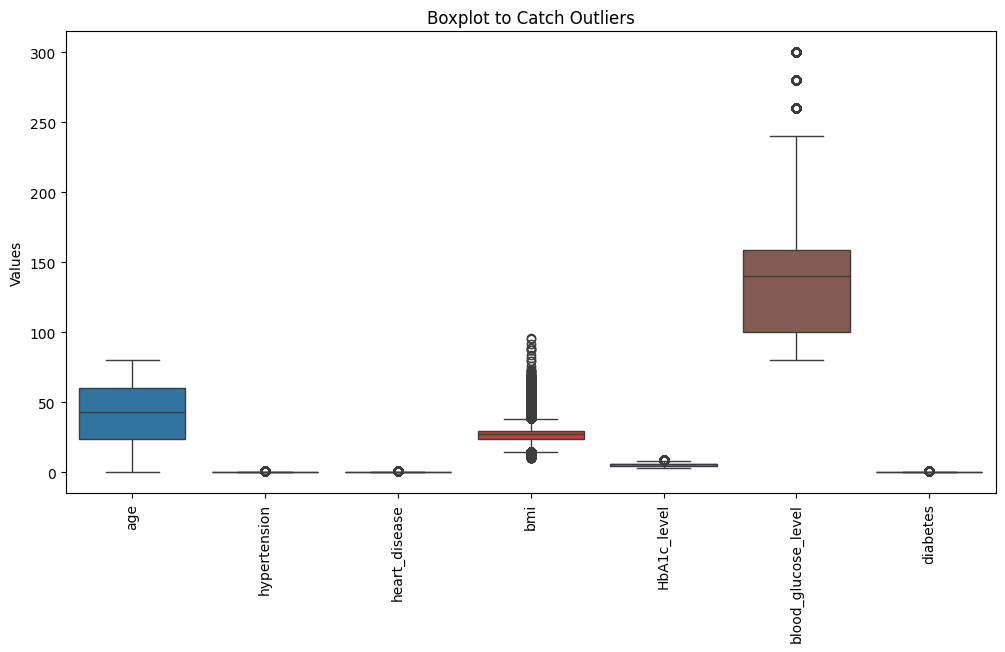

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=dtf)
plt.xticks(rotation=90)
plt.ylabel('Values')
plt.title('Boxplot to Catch Outliers')
plt.show()


####Delete Outliers
The process of deleting outliers involves identifying and removing data points that significantly deviate from the majority of observations in a dataset.
Outliers excluded from the dataset to prevent them from unduly influencing analysis or model performance.

In [ ]:
test = dtf[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']]
z = np.abs(stats.zscore(test))
data = dtf[(z < 3).all(axis=1)]

### Delete duplicates

In [ ]:
data = data.drop_duplicates()
data.shape

(90471, 9)

## Handling Categorical Features

The dataset contains both binary (gender, hypertension, heart disease, diabetes) and categorical (smoking history) attributes.

For the categorical attribute 'gender' - we replaced Male with 1 and Female with '2'.

For the categorical attribute 'smoking_history' - we replaced never, current, former, not current and ever with 5-1 respectivly.

In [ ]:
# trate Other as female
dtf['gender'].replace({'Male': 1, 'Female': 2}, inplace=True)

dtf['smoking_history'].replace({'never': 5, 'current': 4, 'former':3,
                                'not current': 2, 'ever': 1}, inplace=True)

dtf.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,2,80.0,0,1,5,25.19,6.6,140,0
1,2,54.0,0,0,5,27.32,6.6,80,0
2,1,28.0,0,0,5,27.32,5.7,158,0
3,2,36.0,0,0,4,23.45,5.0,155,0
4,1,76.0,1,1,4,20.14,4.8,155,0


## Gather Information About the Data

See diabetes distribution over Male vs. Female

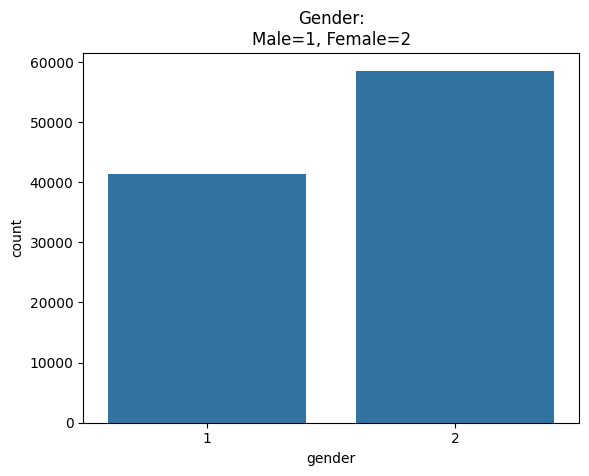

In [ ]:
sns.countplot(data = dtf, x = 'gender')
plt.title('Gender:\nMale=1, Female=2')
plt.show()


See diabetes distribution for smoking history:

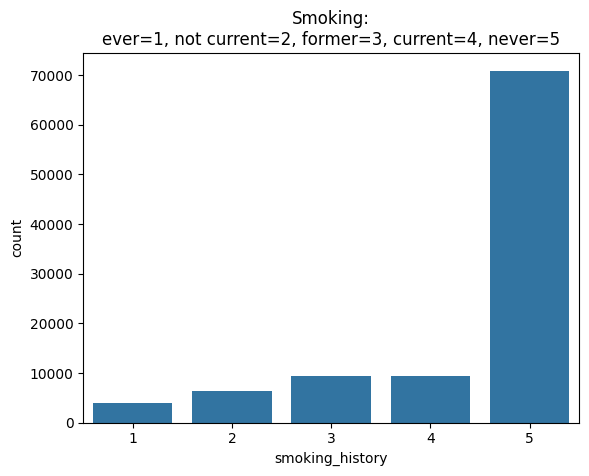

In [ ]:
sns.countplot(data = dtf, x = 'smoking_history')
plt.title('Smoking:\never=1, not current=2, former=3, current=4, never=5')
plt.show()


#### Examining Correlations: Diabetes

Calculate the Pearson correlation coefficients between the 'diabetes' attribute and all other attributes in the dataset. Pearson correlation coefficient measures the linear relationship between two variables, ranging from -1 to 1, where 1 indicates a perfect positive linear relationship, -1 indicates a perfect negative linear relationship, and 0 indicates no linear relationship.

<Axes: >

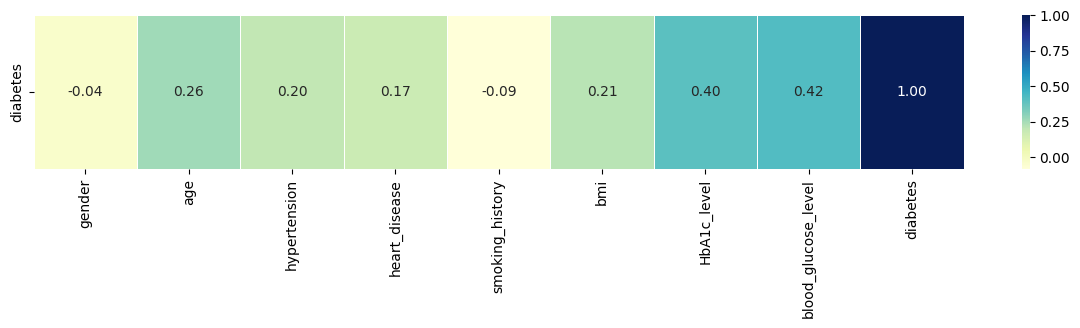

In [ ]:
dtf_corr = dtf.corr(method="pearson").loc[["diabetes"]]
fig, ax = plt.subplots(figsize=(15,2))
sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)


Visualize the distribution of numerical attributes in the dataset using histograms.

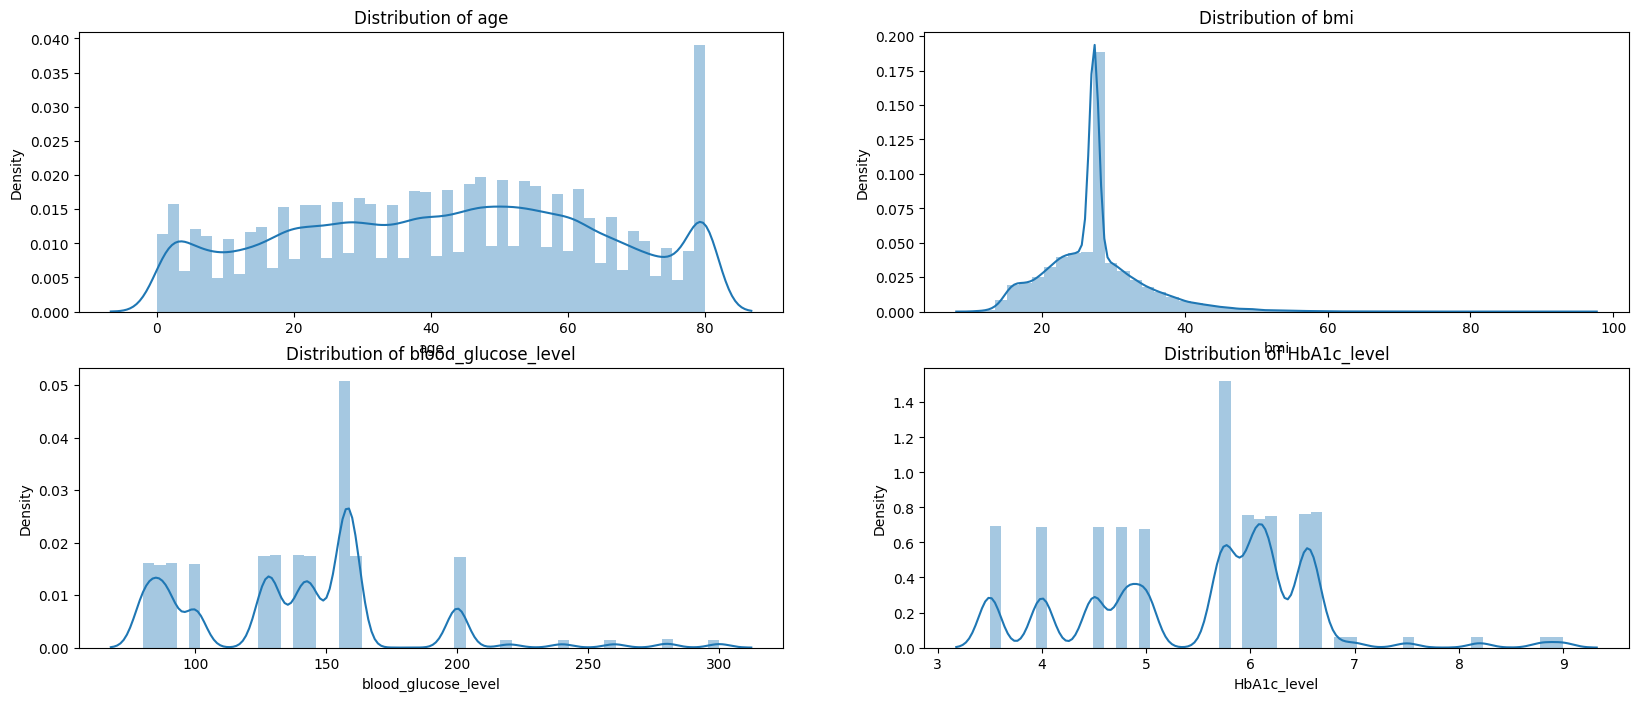

In [ ]:
numerical = ['age', 'bmi', 'blood_glucose_level', 'HbA1c_level']

# Create a figure and axis object outside the loop
fig, axes = plt.subplots(2, 2, figsize=(20, 8))

# Flatten the axes array for easy indexing
axes = axes.flatten()

for i, col in enumerate(numerical):
    sns.distplot(dtf[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# Save the figure
plt.savefig('2')

# Show the figure
plt.show()


### Correlation Between The Features


Heatmap to visualize the correlation between the features in the dataset.

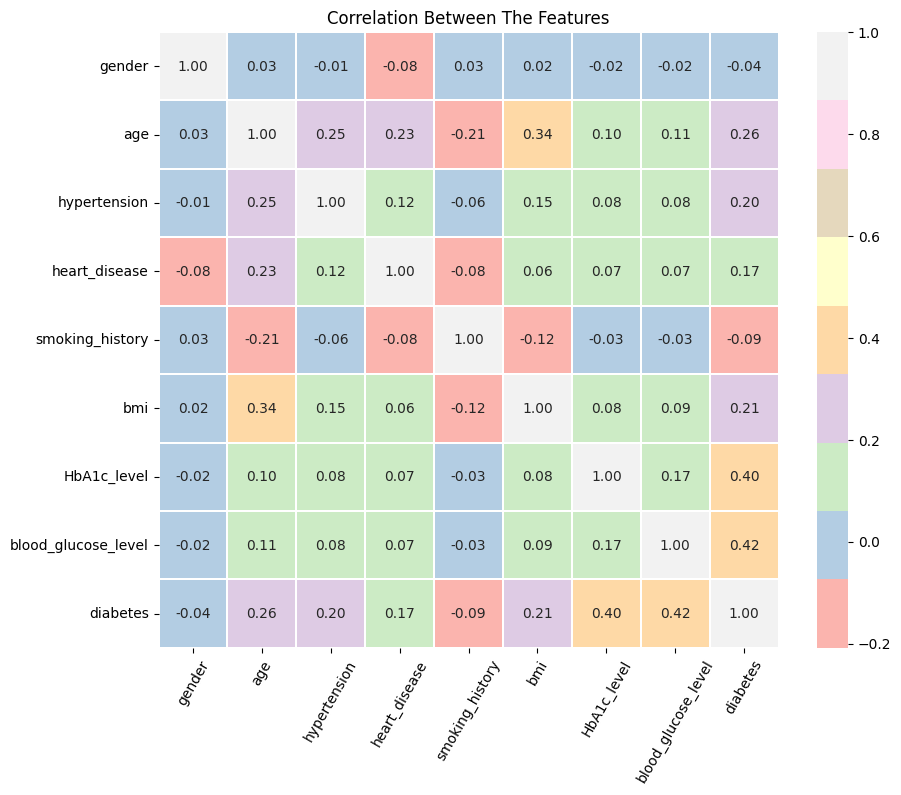

In [ ]:
plt.figure(figsize=(10, 8))
plt.title('Correlation Between The Features')
heatmap = sns.heatmap(dtf.corr(), annot=True, cmap='Pastel1', fmt='.2f', linewidths=0.2)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=60)
heatmap.set_yticklabels(heatmap.get_yticklabels())
plt.show()


The aim is to predict the likelihood of diabetes in patients based on their medical history and demographic details - gender, BMI, age, smoking history.

Our target value : **Diabetes**.



## One hot encoding

One-hot encoding is a technique used to represent categorical variables as binary vectors. In this encoding scheme, each category or level of the categorical variable is represented as a binary vector, where only one element is "hot" (1) while all others are "cold" (0).`

In [ ]:
dtf = pd.get_dummies(dtf)

# Classification Model training

## XGboost model - pipeline

In [ ]:
# Separate features and target
features = dtf.drop('diabetes', axis=1)
target = dtf['diabetes']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create an XGBoost classifier
model = xgb.XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("XGboost model performance:")
print("   * Accuracy:", accuracy)
print("   * Precision:", precision)
print("   * Recall:", recall)
print("   * F1 Score:", f1)

XGboost model performance:
   * Accuracy: 0.9705455818372756
   * Precision: 0.9589783281733746
   * Recall: 0.6980281690140845
   * F1 Score: 0.807955656993805


## Cross validation
Cross-validation is a statistical technique used to assess the performance of a model.
 Common cross-validation techniques include k-fold cross-validation.
 The model is then trained k times, each time using a different fold as the validation set and the remaining k-1 folds as the training set. This process ensures that each data point is used for validation exactly once and allows for a more reliable estimation of the model's performance. The final performance metric is typically computed as the average of the performance scores obtained across all k folds.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Create KFold cross-validation object
kfold = KFold(n_splits=10)

# Evaluate the model’s predictive results in a 10 fold cross-validation process
scores = cross_val_score(model, features, target, cv=kfold)

# Print average accuracy
print("Average accuracy:", scores.mean())

Average accuracy: 0.9712248380269113


## Improving and scaling feature
Ensure that all features are on a similar scale to prevent some features from dominating others in the learning process.

In [ ]:
#  Perform scaling for dtf
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

## Handling data imbalance
Handling data imbalance involves addressing situations where the distribution of classes in a dataset is highly skewed, potentially leading to biased model performance.

The next code snippet demonstrates the implementation of random oversampling using the RandomOverSampler from the imblearn library in Python. Random oversampling is a technique used to address class imbalance in datasets by increasing the number of instances in the minority class(es) through replication.

In [ ]:
# use random oversampler
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler()
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

Training the model using balanced data achieved through resampling techniques.
By fitting the model on the resampled training data, we aimed to mitigate the effects of class imbalance.
We then made predictions on the test set and evaluated the model's performance using metrics such as accuracy, precision, recall, and F1 score.

In [ ]:
# Train the model with balanced data
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)


Accuracy: 0.9211381707256089
Recall: 0.8873239436619719
Precision: 0.5335365853658537
F1 Score: 0.6663845991114873


**Metrics are better in the base model**

# Random Forest model
A Random Forest model is a popular ensemble learning technique used for both classification and regression tasks.
It consists of a collection of decision trees, where each tree is trained on a random subset of the training data and selects a random subset of features at each split.
For classification tasks, it involves using voting to determine the most common class label.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
rfc = RandomForestClassifier()

# Train the model
rfc.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rfc = rfc.predict(X_test)

# Evaluate the model performance
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
precision_rfc = precision_score(y_test, y_pred_rfc)
recall_rfc = recall_score(y_test, y_pred_rfc)
f1_rfc = f1_score(y_test, y_pred_rfc)

print("Accuracy:", accuracy_rfc)
print("Precision:", precision_rfc)
print("Recall:", recall_rfc)
print("F1 Score:", f1_rfc)

# Perform cross-validation
scores_rfc = cross_val_score(rfc, features, target, cv=kfold)

# Print average accuracy
print("Average accuracy:", scores_rfc.mean())

Accuracy: 0.969495424313647
Precision: 0.9512006196746708
Recall: 0.691830985915493
F1 Score: 0.8010437051532941
Average accuracy: 0.9697945709754011


# Classication Report

In [ ]:
import matplotlib.pyplot as plt
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96     18222
           1       0.53      0.89      0.67      1775

    accuracy                           0.92     19997
   macro avg       0.76      0.91      0.81     19997
weighted avg       0.95      0.92      0.93     19997



The classification report allows you to quickly assess how well your model is performing for each class, which is particularly important in cases of imbalanced datasets where certain classes might be underrepresented. By examining precision, recall, and F1 score for each class, you can gain insights into where your model is performing well and where it might need improvement.

# Confusion matrix
A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. It's a square matrix where the rows represent the actual classes and the columns represent the predicted classes. Each cell in the matrix represents the count of instances that belong to the combination of the actual class and the predicted class.

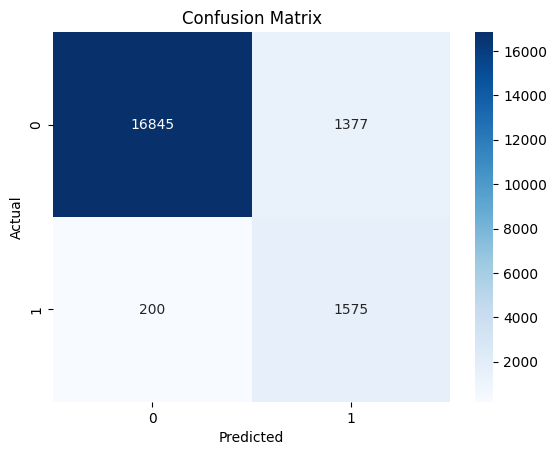

In [ ]:
# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Model Interpretabilty

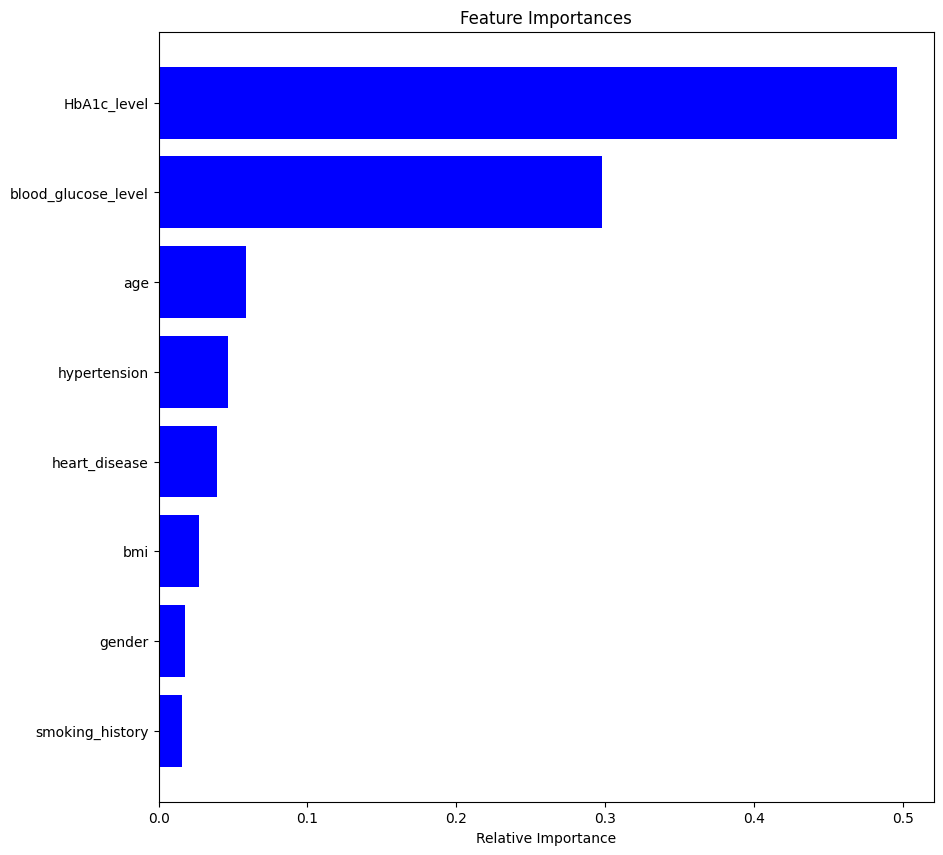

In [ ]:
# feature importance bar chart

import matplotlib.pyplot as plt
import numpy as np
importances = model.feature_importances_
features = features.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**'Hba1c_level' and 'blood glucose level' are the most important and relavant to make the diabetics prediction**

# SHAP Analysis


SHAP (SHapley Additive exPlanations)

SHAP is a method for explaining individual predictions in machine learning models. It calculates the contribution of each feature to a prediction, providing local interpretability. By considering all possible combinations of features, SHAP computes Shapley values, which represent the importance of each feature. SHAP helps understand model decisions, aids in feature engineering, and can diagnose biases. In Python, SHAP can be implemented using the shap library.

In [ ]:
! pip install shap

## Summary plot of all features

The summary plot shows the feature importance of each feature in the model.



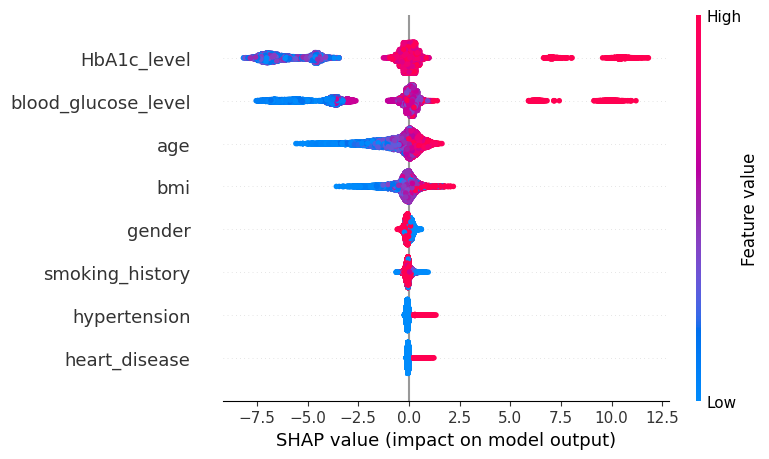

In [ ]:
# create shap plots

import shap

# Load the model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Create a Shap explainer
explainer = shap.Explainer(model)

# Generate Shap values for the test set
shap_values = explainer(X_test)

# Create a Shap summary plot
shap.summary_plot(shap_values, X_test)

The first four features have a large variation than others so those are more important to the XGboost model

## Bar plot of all the features

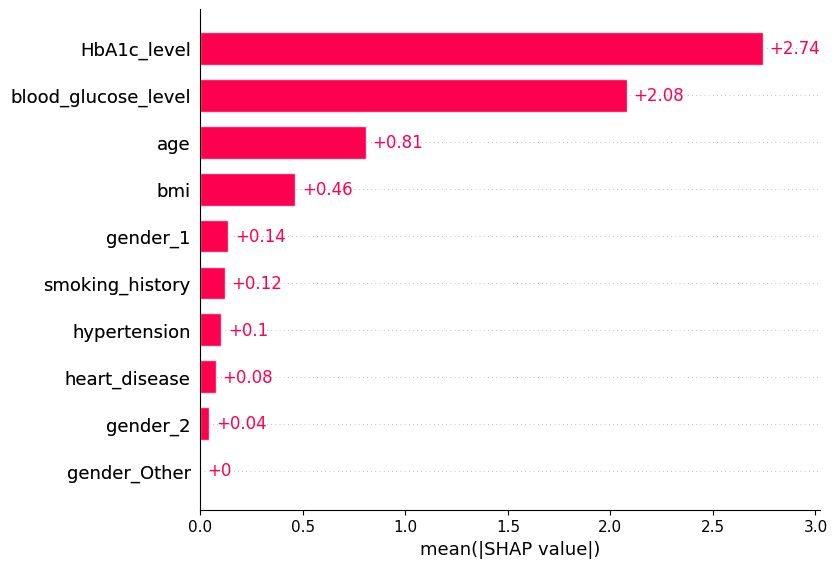

In [ ]:
# prompt: another plot

shap.plots.bar(shap_values)

Highest values have the high importance and lower values means there is less importance for the model prediction

# Conclusion
In this study, we developed a robust machine learning model for predicting diabetes risk leveraging the power of XGBoost and Random Forest algorithms. Prior to model training, we meticulously preprocessed the dataset, addressing missing values, feature scaling, and categorical encoding, ensuring data quality and compatibility with our models.

Both XGBoost and Random Forest algorithms exhibited commendable performance in predicting diabetes onset, achieving high accuracy and robustness. Through rigorous evaluation and comparison, we observed that XGBoost slightly outperformed Random Forest in terms of predictive accuracy, highlighting its efficacy for this particular task.

Furthermore, to gain insights into the model's decision-making process and feature importance, we employed SHAP (SHapley Additive exPlanations) values. SHAP analysis revealed valuable insights into the relative importance of different features in predicting diabetes risk. Key factors such as glucose level and HbA1c_level emerged as significant contributors to the predictive outcome, aligning with established medical knowledge.

In conclusion, our developed ML model, leveraging XGBoost and Random Forest algorithms, coupled with SHAP interpretation, not only provides accurate predictions of diabetes risk but also offers valuable insights into the underlying factors driving these predictions. This model holds great promise for aiding clinicians in early detection and intervention, ultimately improving patient outcomes and healthcare management in the realm of diabetes.
